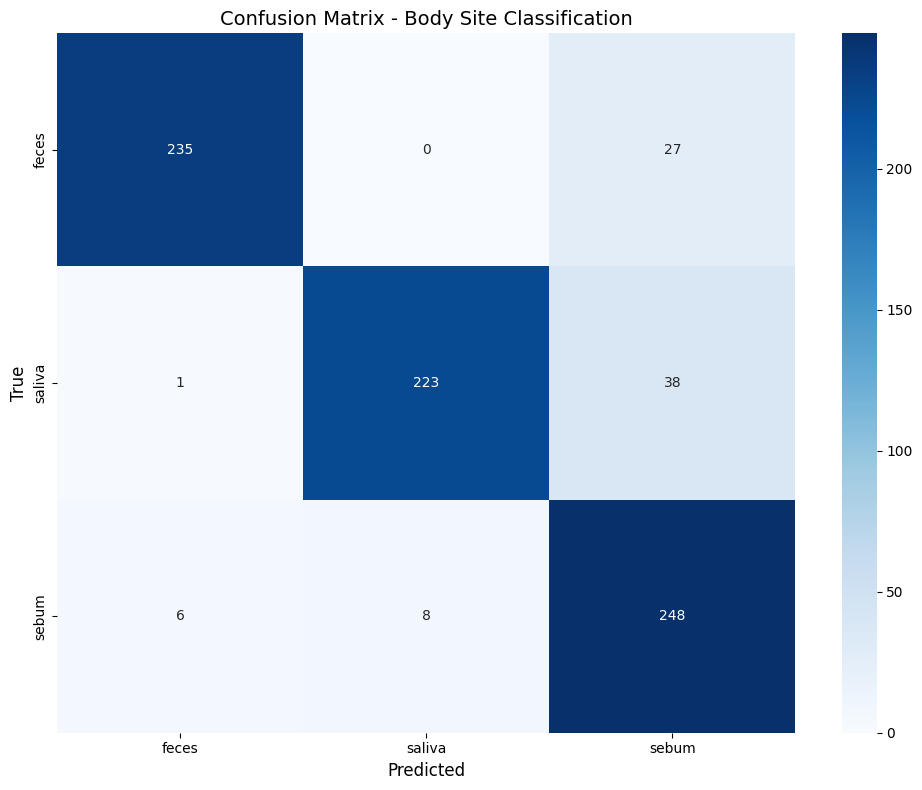

Training final model:   0%|          | 0/50 [00:00<?, ?it/s]

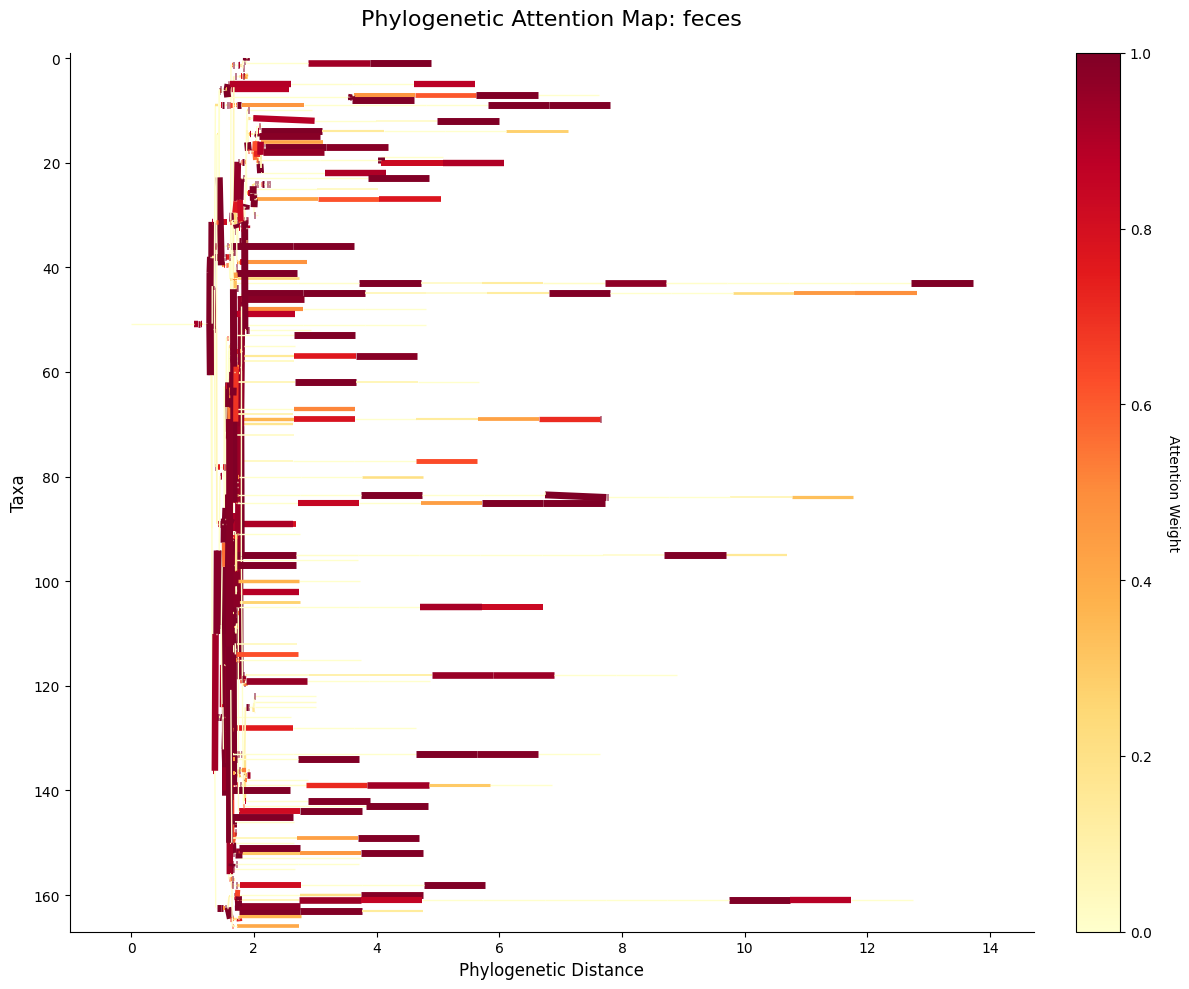

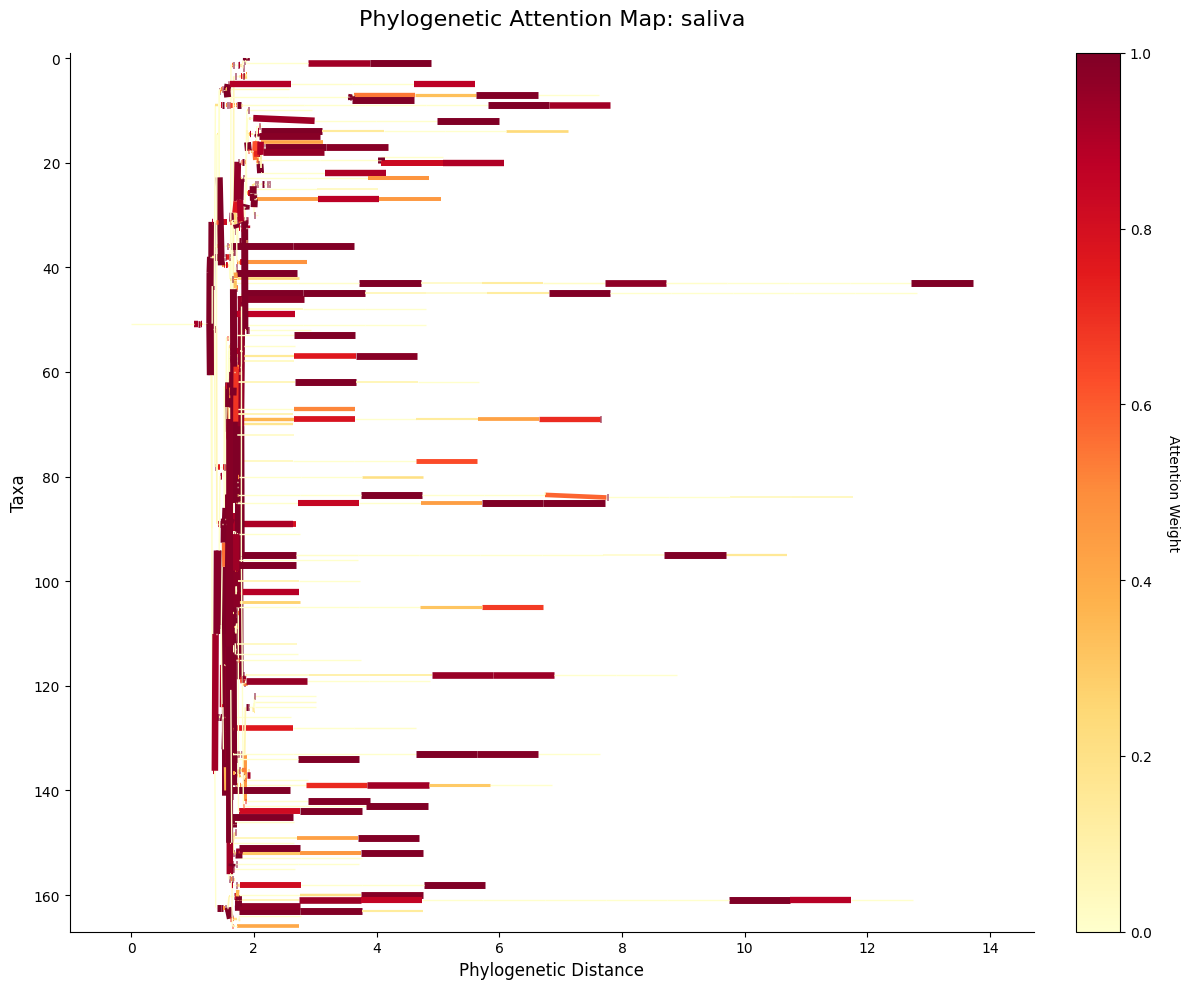

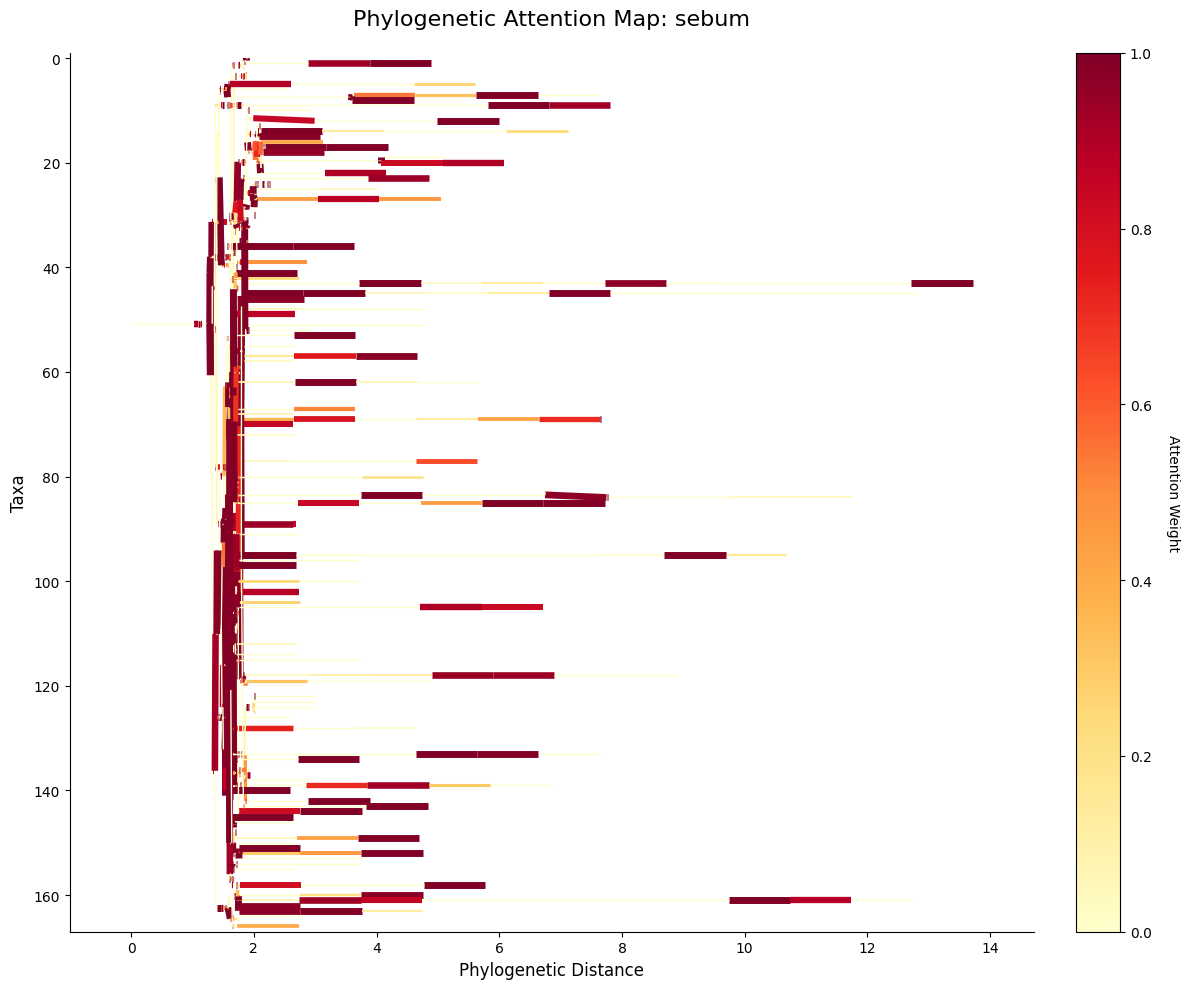

In [1]:
'''
# Host Body-Site Classification GAT

Phylogenetic GAT + MLP to classify host_body_site from microbiome profiles,
outputting both performance plots and per-class phylogenies with learned attention.
'''
# !pip install torch torch-geometric numpy pandas scikit-learn dendropy biopython networkx tqdm matplotlib biom-format mlflow
# Imports
import os
import json
import logging
import datetime
from pathlib import Path
from dataclasses import dataclass, asdict
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.collections import LineCollection
import seaborn as sns
from biom import load_table
import dendropy
from Bio import Phylo
from tqdm.auto import tqdm
import networkx as nx
import mlflow
import warnings
warnings.filterwarnings('ignore')

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Configuration
@dataclass
class Config:
    """Configuration for the experiment"""
    # Data paths
    data_dir: str = 'data'
    feat_file: str = '127152_reference-hit.biom'
    tree_file: str = '127152_insertion_tree.relabelled.tre'
    meta_file: str = 'sample_information_from_prep_72.tsv'

    # Model parameters
    feat_emb: int = 128
    gnn_hid: int = 128
    mlp_hid: int = 128
    dropout: float = 0.2

    # Training parameters
    n_folds: int = 5
    epochs: int = 50
    lr: float = 1e-3
    weight_decay: float = 1e-2
    batch_size: int = 16
    patience: int = 10

    # Preprocessing
    min_prevalence: float = 0.1
    min_samples_per_group: int = 2

    # Output
    output_dir: str = 'outputs'
    save_models: bool = True
    save_plots: bool = True

    # Device
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'

    def save(self, path: str):
        """Save configuration to JSON"""
        with open(path, 'w') as f:
            json.dump(asdict(self), f, indent=2)

    @classmethod
    def load(cls, path: str):
        """Load configuration from JSON"""
        with open(path, 'r') as f:
            return cls(**json.load(f))

# Helper Classes and Functions
class PhyloTreeProcessor:
    '''Fast induced-subtree graph builder with caching and pruning.'''
    def __init__(self):
        self._cache = {}
        self.last_tree = None
        self.last_node_list = None
        self.last_idx_map = None
        self.last_edge_index = None
        self.last_edge_map = None

    def tree_to_graph(self, tree_file, feature_names=None):
        fnames = list(feature_names) if feature_names is not None else None
        key = (tree_file, frozenset(fnames)) if fnames is not None else None

        if key is not None and key in self._cache:
            result = self._cache[key]
            edge_index, edge_attr, num_nodes, tree, node_list, idx_map, edge_map = result
            self.last_tree = tree
            self.last_node_list = node_list
            self.last_idx_map = idx_map
            self.last_edge_index = edge_index
            self.last_edge_map = edge_map
            return edge_index, edge_attr, num_nodes

        tree = dendropy.Tree.get(path=tree_file, schema='newick')

        if fnames is not None:
            wanted = set(fnames)
            keep = set()
            for leaf in tree.leaf_node_iter():
                lbl = leaf.taxon.label if leaf.taxon else None
                if lbl in wanted:
                    node = leaf
                    while node:
                        keep.add(node)
                        node = node.parent_node
        else:
            keep = set(tree.preorder_node_iter())

        node_list = list(keep)
        idx_map = {n: i for i, n in enumerate(node_list)}

        edges, weights = [], []
        edge_map = {}  # Map from edge index to (parent_idx, child_idx)

        for n in node_list:
            p = n.parent_node
            if p in keep:
                u, v = idx_map[p], idx_map[n]
                w = n.edge_length or 1.0

                # Store edge mapping for attention visualization
                edge_idx = len(edges) // 2
                edge_map[edge_idx] = (u, v)

                edges.extend([[u, v], [v, u]])
                weights.extend([w, w])

        edge_index = torch.tensor(edges, dtype=torch.long).T
        edge_attr = torch.tensor(weights, dtype=torch.float).unsqueeze(1)
        num_nodes = len(node_list)

        if key is not None:
            self._cache[key] = (edge_index, edge_attr, num_nodes, tree, node_list, idx_map, edge_map)

        self.last_tree = tree
        self.last_node_list = node_list
        self.last_idx_map = idx_map
        self.last_edge_index = edge_index
        self.last_edge_map = edge_map

        return edge_index, edge_attr, num_nodes

class PhyloGAT(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, heads=4, dropout=0.2):
        super().__init__()
        self.conv1 = GATConv(in_dim, hid_dim, heads=heads, dropout=dropout, concat=True)
        self.bn1 = nn.BatchNorm1d(hid_dim * heads)
        self.conv2 = GATConv(hid_dim * heads, out_dim, heads=1, concat=False, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self._last_attention = None

    def forward(self, x, edge_index, edge_weight=None):
        x1, (edge_idx1, att1) = self.conv1(x, edge_index, return_attention_weights=True)
        x1 = F.elu(self.bn1(x1))
        x1 = self.dropout(x1)

        x2, (edge_idx2, att2) = self.conv2(x1, edge_index, return_attention_weights=True)

        # Store attention weights
        self._last_attention = att2
        self._last_edge_index = edge_idx2

        return x2

class HostBodySiteGAT(nn.Module):
    def __init__(self, num_nodes, num_classes, config: Config):
        super().__init__()
        self.config = config
        self.node_lin = nn.Linear(1, config.feat_emb)
        self.internal_emb = nn.Embedding(num_nodes, config.feat_emb)
        self.gnn = PhyloGAT(config.feat_emb, config.gnn_hid, config.gnn_hid,
                           heads=4, dropout=config.dropout)
        self.mlp = nn.Sequential(
            nn.Linear(config.gnn_hid, config.mlp_hid),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.mlp_hid, num_classes)
        )

    def forward(self, data):
        h0 = self.node_lin(data.x) + self.internal_emb(data.node_id)
        h = self.gnn(h0, data.edge_index, data.edge_attr)
        z = global_mean_pool(h, data.batch)
        return self.mlp(z)

# Data loading functions
def load_feature_table(biom_fp):
    """Load feature table from biom file"""
    logger.info(f"Loading feature table from {biom_fp}")
    table = load_table(biom_fp)
    df = table.to_dataframe(dense=True).T
    return df.astype(float)

def load_metadata(meta_fp):
    """Load metadata file"""
    logger.info(f"Loading metadata from {meta_fp}")
    df = pd.read_csv(meta_fp, sep='\t')
    idx = 'sample' if 'sample' in df.columns else df.columns[0]
    df = df.set_index(idx)
    for c in ('host', 'env_material'):
        if c not in df.columns:
            raise ValueError(f"metadata must contain '{c}' column")
    return df[['host', 'env_material']]

def preprocess_data(X, meta, config: Config):
    """Preprocess data according to configuration"""
    logger.info("Preprocessing data...")

    # Filter samples with enough replicates
    meta = meta.groupby(['host', 'env_material']).filter(
        lambda x: len(x) >= config.min_samples_per_group
    )

    # Balance classes
    minc = meta.groupby(['host', 'env_material']).size().min()
    meta = meta.groupby(['host', 'env_material']).sample(n=minc, random_state=42)

    # Filter features by prevalence
    X = X.loc[meta.index]
    prev = (X > 0).sum(axis=0) / X.shape[0]
    X = X.loc[:, prev >= config.min_prevalence]

    logger.info(f"Final data shape: {X.shape}")
    return X, meta

def build_data_list(X, y, edge_index, edge_attr, num_nodes):
    """Build PyG data list"""
    data_list = []
    for i in range(len(X)):
        x = torch.tensor(X.iloc[[i]].T.values, dtype=torch.float)
        pad = num_nodes - x.size(0)
        if pad > 0:
            x = torch.cat([x, torch.zeros(pad, 1)], dim=0)
        data = Data(
            x=x,
            edge_index=edge_index,
            edge_attr=edge_attr,
            y=torch.tensor(y[i], dtype=torch.long),
            node_id=torch.arange(num_nodes)
        )
        data_list.append(data)
    return data_list

# Plotting functions
def plot_confusion(cm, labels, save_path=None):
    """Plot confusion matrix"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.title('Confusion Matrix - Body Site Classification', fontsize=14)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def get_phylo_coords_fast(tree, node_list):
    """Get x,y coordinates for tree nodes - optimized version"""
    # Get leaf nodes
    leaves = [n for n in tree.leaf_node_iter() if n in node_list]
    leaves.sort(key=lambda n: n.taxon.label if n.taxon else '')

    # Assign y-coordinates to leaves
    y_coords = {leaf: i for i, leaf in enumerate(leaves)}

    # Assign y-coordinates to internal nodes (average of children)
    for node in tree.postorder_node_iter():
        if node not in y_coords and node in node_list:
            children = [c for c in node.child_node_iter() if c in y_coords]
            if children:
                y_coords[node] = sum(y_coords[c] for c in children) / len(children)

    # Assign x-coordinates based on distance from root
    x_coords = {}
    def _assign_x(n, dist):
        if n in node_list:
            x_coords[n] = dist
        for c in n.child_node_iter():
            _assign_x(c, dist + (c.edge_length or 1.0))

    _assign_x(tree.seed_node, 0.0)

    return x_coords, y_coords

def plot_attention_phylogeny_improved(proc, attention_weights, class_name,
                                    save_path=None, figsize=(12, 10),
                                    cmap='hot', top_pct=0.2, show_labels=False):
    """
    Improved phylogenetic tree visualization with attention weights.
    Uses matplotlib LineCollection for efficient rendering.

    Parameters:
    -----------
    show_labels : bool, default=False
        Whether to show taxon labels for highly attended leaves
    """
    # Get tree structure
    tree = proc.last_tree
    node_list = proc.last_node_list
    idx_map = proc.last_idx_map
    edge_index = proc.last_edge_index

    # Get coordinates
    x_coords, y_coords = get_phylo_coords_fast(tree, node_list)

    # Prepare edge segments and attention values
    segments = []
    attention_values = []

    # Process attention weights
    att_numpy = attention_weights.detach().cpu().numpy().flatten()

    # Create edge segments
    edge_pairs = edge_index.T.numpy()
    for i in range(0, len(edge_pairs), 2):  # Skip reverse edges
        u, v = edge_pairs[i]
        if u < len(node_list) and v < len(node_list):
            node_u = node_list[u]
            node_v = node_list[v]

            if node_u in x_coords and node_v in x_coords:
                x1, y1 = x_coords[node_u], y_coords[node_u]
                x2, y2 = x_coords[node_v], y_coords[node_v]
                segments.append([(x1, y1), (x2, y2)])

                # Get attention weight for this edge
                if i < len(att_numpy):
                    attention_values.append(att_numpy[i])
                else:
                    attention_values.append(0.0)

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Normalize attention values
    attention_array = np.array(attention_values)
    if attention_array.max() > attention_array.min():
        attention_norm = (attention_array - attention_array.min()) / (attention_array.max() - attention_array.min())
    else:
        attention_norm = attention_array

    # Create LineCollection
    lc = LineCollection(segments, linewidths=1 + attention_norm * 4,
                       cmap=plt.get_cmap(cmap))
    lc.set_array(attention_norm)

    # Add to plot
    ax.add_collection(lc)

    # Add colorbar
    cbar = plt.colorbar(lc, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Attention Weight', rotation=270, labelpad=20)

    # Optional: Show labels or markers for highly attended leaf nodes
    if show_labels:
        threshold = np.percentile(attention_norm, 100 * (1 - top_pct))
        for node in tree.leaf_node_iter():
            if node in node_list:
                idx = idx_map[node]
                x, y = x_coords[node], y_coords[node]

                # Check if this leaf has high attention
                leaf_attention = 0
                for i, (u, v) in enumerate(edge_pairs[::2]):
                    if v == idx and i < len(attention_norm):
                        leaf_attention = attention_norm[i]
                        break

                if leaf_attention >= threshold and node.taxon:
                    # Option 1: Show full labels (may be long sequences)
                    # ax.text(x + 0.5, y, node.taxon.label,
                    #        fontsize=8, va='center', ha='left',
                    #        color='darkred', weight='bold')

                    # Option 2: Show truncated labels
                    label = node.taxon.label[:20] + '...' if len(node.taxon.label) > 20 else node.taxon.label
                    ax.text(x + 0.5, y, label,
                           fontsize=8, va='center', ha='left',
                           color='darkred', weight='bold')

                    # Option 3: Just mark with a dot
                    # ax.scatter(x, y, s=50, c='darkred', marker='o', zorder=10)

    # Set plot properties
    x_padding = 10 if show_labels else 1
    ax.set_xlim(min(x_coords.values()) - 1, max(x_coords.values()) + x_padding)
    ax.set_ylim(min(y_coords.values()) - 1, max(y_coords.values()) + 1)
    ax.invert_yaxis()
    ax.set_title(f'Phylogenetic Attention Map: {class_name}', fontsize=16, pad=20)
    ax.set_xlabel('Phylogenetic Distance', fontsize=12)
    ax.set_ylabel('Taxa', fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Training functions
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    losses = []

    for batch in loader:
        batch = batch.to(device)
        out = model(batch)
        loss = criterion(out, batch.y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    return np.mean(losses)

def evaluate(model, loader, device):
    """Evaluate model"""
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            pred = out.argmax(dim=1)

            preds.extend(pred.cpu().numpy())
            labels.extend(batch.y.cpu().numpy())

    return np.array(labels), np.array(preds)

def run_cv_experiment(X, y, groups, edge_index, edge_attr, num_nodes,
                     num_classes, body_sites, config: Config):
    """Run cross-validation experiment with MLflow tracking"""

    # Create output directory
    output_dir = Path(config.output_dir)
    output_dir.mkdir(exist_ok=True)

    # Initialize MLflow
    mlflow.set_experiment("phylo_gat_body_site")

    with mlflow.start_run():
        # Log configuration
        mlflow.log_params(asdict(config))

        # Save config
        config_path = output_dir / 'config.json'
        config.save(str(config_path))
        mlflow.log_artifact(str(config_path))

        # Cross-validation
        skf = StratifiedKFold(n_splits=config.n_folds, shuffle=True, random_state=42)
        results = []
        all_preds, all_labels = [], []

        for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
            logger.info(f"Training fold {fold}/{config.n_folds}")

            # Split train into train/val
            n_val = int(0.2 * len(train_idx))
            tr_idx, val_idx = train_idx[:-n_val], train_idx[-n_val:]

            # Create data splits
            splits = {'train': tr_idx, 'val': val_idx, 'test': test_idx}

            # Scale features
            scaler = MaxAbsScaler()
            loaders = {}

            for name, idxs in splits.items():
                Xi_raw = X.iloc[idxs]
                Xi = scaler.fit_transform(Xi_raw) if name == 'train' else scaler.transform(Xi_raw)
                Xi_df = pd.DataFrame(Xi, index=X.index[idxs], columns=X.columns)

                data_list = build_data_list(Xi_df, y[idxs], edge_index, edge_attr, num_nodes)
                loaders[name] = DataLoader(data_list, batch_size=config.batch_size,
                                         shuffle=(name == 'train'))

            # Create model
            model = HostBodySiteGAT(num_nodes, num_classes, config).to(config.device)
            optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr,
                                        weight_decay=config.weight_decay)
            criterion = nn.CrossEntropyLoss()

            # Training loop
            best_val_loss = float('inf')
            patience_counter = 0

            for epoch in range(1, config.epochs + 1):
                # Train
                train_loss = train_epoch(model, loaders['train'], criterion, optimizer, config.device)

                # Validate
                val_labels, val_preds = evaluate(model, loaders['val'], config.device)
                val_acc = accuracy_score(val_labels, val_preds)

                # Early stopping
                val_loss = -val_acc  # Use negative accuracy as loss
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0

                    # Save best model
                    if config.save_models:
                        model_path = output_dir / f'best_model_fold{fold}.pt'
                        torch.save(model.state_dict(), model_path)
                else:
                    patience_counter += 1
                    if patience_counter >= config.patience:
                        logger.info(f"Early stopping at epoch {epoch}")
                        break

                if epoch % 10 == 0:
                    logger.info(f"Epoch {epoch}: train_loss={train_loss:.4f}, val_acc={val_acc:.4f}")

            # Load best model and evaluate on test set
            if config.save_models:
                model.load_state_dict(torch.load(model_path))

            test_labels, test_preds = evaluate(model, loaders['test'], config.device)
            test_acc = accuracy_score(test_labels, test_preds)

            results.append({
                'fold': fold,
                'accuracy': test_acc,
                'n_train': len(tr_idx),
                'n_val': len(val_idx),
                'n_test': len(test_idx)
            })

            all_preds.extend(test_preds)
            all_labels.extend(test_labels)

            # Log fold results
            mlflow.log_metric(f'fold_{fold}_accuracy', test_acc)
            logger.info(f"Fold {fold} Test Accuracy: {test_acc:.4f}")

        # Overall results
        results_df = pd.DataFrame(results)
        mean_acc = results_df['accuracy'].mean()
        std_acc = results_df['accuracy'].std()

        logger.info(f"\nOverall CV Results:")
        logger.info(f"Mean Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")

        # Log overall metrics
        mlflow.log_metric('mean_accuracy', mean_acc)
        mlflow.log_metric('std_accuracy', std_acc)

        # Save results
        results_path = output_dir / 'cv_results.csv'
        results_df.to_csv(results_path, index=False)
        mlflow.log_artifact(str(results_path))

        # Confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        if config.save_plots:
            cm_path = output_dir / 'confusion_matrix.png'
            plot_confusion(cm, body_sites, save_path=cm_path)
            mlflow.log_artifact(str(cm_path))

        # Classification report
        report = classification_report(all_labels, all_preds,
                                     target_names=body_sites, output_dict=True)
        report_df = pd.DataFrame(report).T
        report_path = output_dir / 'classification_report.csv'
        report_df.to_csv(report_path)
        mlflow.log_artifact(str(report_path))

        return results_df, all_labels, all_preds

def train_final_model(X, y, edge_index, edge_attr, num_nodes, num_classes,
                     body_sites, proc, config: Config):
    """Train final model on all data and generate attention visualizations"""
    logger.info("Training final model for attention visualization...")

    # Create output directory for plots
    plot_dir = Path(config.output_dir) / 'attention_plots'
    plot_dir.mkdir(exist_ok=True)

    # Scale features
    scaler = MaxAbsScaler()
    X_scaled = scaler.fit_transform(X)
    X_df = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

    # Create data
    data_list = build_data_list(X_df, y, edge_index, edge_attr, num_nodes)
    loader = DataLoader(data_list, batch_size=config.batch_size, shuffle=True)

    # Create and train model
    model = HostBodySiteGAT(num_nodes, num_classes, config).to(config.device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr,
                                weight_decay=config.weight_decay)
    criterion = nn.CrossEntropyLoss()

    # Train
    for epoch in tqdm(range(1, min(config.epochs, 50) + 1), desc='Training final model'):
        train_loss = train_epoch(model, loader, criterion, optimizer, config.device)

        if epoch % 10 == 0:
            logger.info(f"Epoch {epoch}: loss={train_loss:.4f}")

    # Generate attention plots for each class
    model.eval()

    for cls_idx, cls_name in enumerate(body_sites):
        logger.info(f"Generating attention plot for {cls_name}")

        # Collect attention weights for this class
        attention_list = []

        with torch.no_grad():
            for i, data in enumerate(data_list):
                if y[i] == cls_idx:
                    batch = data.to(config.device)
                    _ = model(batch)

                    # Get attention weights
                    if model.gnn._last_attention is not None:
                        attention_list.append(model.gnn._last_attention)

        if attention_list:
            # Average attention weights
            att_stack = torch.stack(attention_list, dim=0)
            avg_attention = att_stack.mean(dim=0)

            # Plot
            plot_path = plot_dir / f'attention_{cls_name.replace(" ", "_")}.png'
            plot_attention_phylogeny_improved(
                proc, avg_attention, cls_name,
                save_path=plot_path,
                cmap='YlOrRd',
                top_pct=0.2,
                show_labels=False  # Set to True if you want to see taxon labels
            )

            # Log to MLflow
            if mlflow.active_run():
                mlflow.log_artifact(str(plot_path))

# Main execution
def main():
    """Main execution function"""
    # Load configuration
    config = Config()

    # Setup paths
    data_dir = Path(config.data_dir)
    feat_fp = data_dir / config.feat_file
    tree_fp = data_dir / config.tree_file
    meta_fp = data_dir / config.meta_file

    # Load data
    X = load_feature_table(str(feat_fp))
    meta = load_metadata(str(meta_fp))

    # Find common samples
    common = X.index.intersection(meta.index)
    if len(common) == 0:
        raise ValueError("No matching samples between feature table and metadata.")

    # Log transform
    X = np.log1p(X.loc[common])
    meta = meta.loc[common]

    # Preprocess
    X, meta = preprocess_data(X, meta, config)

    # Prepare labels
    body_sites = sorted(meta.env_material.unique())
    label_map = {s: i for i, s in enumerate(body_sites)}
    y = meta.env_material.map(label_map).values
    groups = meta.host.values

    logger.info(f"Classes: {body_sites}")
    logger.info(f"Class distribution: {np.bincount(y)}")

    # Build phylogenetic graph
    proc = PhyloTreeProcessor()
    edge_index, edge_attr, num_nodes = proc.tree_to_graph(str(tree_fp), feature_names=X.columns)

    logger.info(f"Graph nodes: {num_nodes}, edges: {edge_index.shape[1]}")

    # Run cross-validation experiment
    results_df, all_labels, all_preds = run_cv_experiment(
        X, y, groups, edge_index, edge_attr, num_nodes,
        len(body_sites), body_sites, config
    )

    # Train final model and generate attention plots
    train_final_model(X, y, edge_index, edge_attr, num_nodes,
                     len(body_sites), body_sites, proc, config)

    logger.info("Experiment completed successfully!")

if __name__ == '__main__':
    main()